# Setup

In [547]:
# Add parent directory to current path. Needed for research imports.
import os.path
import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.insert(0,p)

# Enable hot reloading
%load_ext autoreload
%autoreload 2


import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from experiments.irl.datasets import *
from experiments.irl.experiment_utils import *
from research.irl.fair_irl import *
from research.utils import *


logging.basicConfig(level=logging.INFO)
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')

from IPython.display import display, HTML
display(HTML("<style>.container { width:1800px !important; }</style>"))
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_colwidth', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Run experiments

In [619]:
base_exp_info = {
    'EXPERIMENT_NAME': 'rerun_boston_lower_accuracy_5',
    
    'OBJECTIVE_NAMES': ['Acc', 'DemPar', 'EqOpp'],
    # Expert demo parameters
    'DATASET': 'Boston',
    'TARGET_DATASET': 'COMPAS',
    'N_EXPERT_DEMOS': 3,
    'EXPERT_ALGO': None,
    'N_DATASET_SAMPLES': 10_000,
    'MIN_FREQ_FILL_PCT': .2,
    # IRL Loop parameters
    'N_TRIALS': 1,
    'IRL_METHOD': None,
    'EPSILON': .05,
    'MAX_ITER': 4,
    'METHOD': 'highs',
    'IRL_ERROR_NORM_WEIGHTS': False,
    # Plotting parameters
    'NOISE_FACTOR': .02,
    'ANNOTATE': True,
    
    'N_INIT_POLICIES': 1,
    'NON_EXPERT_ALGOS': [
        'OptAccNoisy',
#         'HardtDemParNoisy',
#         'HardtEqOppNoisy',
#             'Dummy',
#         'DummyNoisy',
    ],

    
    
    
#     'IRL_ERROR_NORM_WEIGHTS': True,
}

In [616]:
experiments = [
    {
        'EXPERT_ALGO': 'OptAcc',
        'IRL_METHOD': 'FairIRL',
    },
    {
        'EXPERT_ALGO': 'HardtDemPar',
        'IRL_METHOD': 'FairIRL',
    },
    {
        'EXPERT_ALGO': 'HardtEqOpp',
        'IRL_METHOD': 'FairIRL',
    },
    
    
    {
        'EXPERT_ALGO': 'OptAcc',
        'IRL_METHOD': 'FairIRLFO',
        'EPSILON': .25,
    },
    {
        'EXPERT_ALGO': 'HardtDemPar',
        'IRL_METHOD': 'FairIRLFO',
        'EPSILON': .25,
    },
    {
        'EXPERT_ALGO': 'HardtEqOpp',
        'IRL_METHOD': 'FairIRLFO',
        'EPSILON': .25,
    },
]

In [617]:
# for exp_i, experiment in enumerate(experiments):
#     logging.info('\n\n')
#     logging.info(f"EXPERIMENT {exp_i+1}/{len(experiments)}")
    
#     exp_info = dict(base_exp_info)
    
#     for k in experiment:
#         exp_info[k] = experiment[k]
        
#     run_experiment(exp_info)

In [618]:
exp_info = dict(base_exp_info)

source_X, source_y, source_feature_types = generate_dataset(
    exp_info['DATASET'],
    n_samples=exp_info['N_DATASET_SAMPLES'],
)
    
target_X, target_y, target_feature_types = generate_dataset(
    exp_info['TARGET_DATASET'],
    n_samples=exp_info['N_DATASET_SAMPLES'],
)

for f in source_feature_types['categoric']:
    source_X[f] = source_X[f].astype(str)
    
for f in target_feature_types['categoric']:
    target_X[f] = target_X[f].astype(str)

for exp_i, experiment in enumerate(experiments):
    logging.info('\n\n')
    logging.info(f"EXPERIMENT {exp_i+1}/{len(experiments)}")
    
    exp_info = dict(base_exp_info)
    
    for k in experiment:
        exp_info[k] = experiment[k]
        
    run_experiment(
        exp_info,
        source_X=source_X,
        source_y=source_y,
        source_feature_types=source_feature_types,
        target_X=target_X,
        target_y=target_y,
        target_feature_types=target_feature_types,
    )

INFO:root:


INFO:root:EXPERIMENT 1/6
INFO:root:exp_info: {'EXPERIMENT_NAME': 'rerun_boston_lower_accuracy_5', 'OBJECTIVE_NAMES': ['Acc', 'DemPar', 'EqOpp'], 'DATASET': 'Boston', 'TARGET_DATASET': 'COMPAS', 'N_EXPERT_DEMOS': 3, 'EXPERT_ALGO': 'OptAcc', 'N_DATASET_SAMPLES': 50000, 'MIN_FREQ_FILL_PCT': 0.2, 'N_TRIALS': 1, 'IRL_METHOD': 'FairIRL', 'EPSILON': 0.08, 'MAX_ITER': 4, 'METHOD': 'highs', 'IRL_ERROR_NORM_WEIGHTS': False, 'NOISE_FACTOR': 0.02, 'ANNOTATE': True, 'N_INIT_POLICIES': 1, 'NON_EXPERT_ALGOS': ['OptAccNoisy']}
INFO:root:

TRIAL 0

INFO:root:muE:
[[0.83994054 0.71544765 0.80498496]
 [0.8468781  0.79159702 0.94733397]
 [0.85109019 0.78810821 0.91526784]]
INFO:root:muE_hold:
[[0.86124876 0.77876805 0.90224455]
 [0.85728444 0.76534786 0.86390133]
 [0.84886026 0.823513   0.95457643]]
INFO:root:muL:
[[0.78778779 0.81987799 0.99641745]]
INFO:root:	IRL Loop iteration 1/4 ...
INFO:root:		Allowing negative weights.
INFO:root:		 muL[0] = [0.811 0.611 0.223]
INFO:root:		 mu_delta[0] 

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.840,0.715,0.805,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.847,0.792,0.947,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.851,0.788,0.915,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.788,0.820,0.996,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.811,0.611,0.223,0,0.811,0.817,0.817,0.611,0.606,0.606,0.223,0.197,0.197,0.0,1.0,0.433,-0.207,-0.360,1.000,1.000,0.0,0.0
5,0.849,0.790,0.918,0,0.849,0.857,0.857,0.790,0.794,0.794,0.918,0.925,0.925,0.0,2.0,0.619,0.000,0.381,0.011,0.007,0.0,0.0


INFO:root:muE_target:
[[0.6303155  0.82539252 0.84722222]
 [0.61111111 0.77891603 0.76319759]
 [0.62071331 0.75686508 0.7034166 ]]
INFO:root:target domain muL = [0.624 0.775 0.776]
INFO:root:target domain muE = [0.621 0.787 0.771]
INFO:root:target domain muL_hold = [0.629 0.783 0.799]
INFO:root:


INFO:root:EXPERIMENT 2/6
INFO:root:exp_info: {'EXPERIMENT_NAME': 'rerun_boston_lower_accuracy_5', 'OBJECTIVE_NAMES': ['Acc', 'DemPar', 'EqOpp'], 'DATASET': 'Boston', 'TARGET_DATASET': 'COMPAS', 'N_EXPERT_DEMOS': 3, 'EXPERT_ALGO': 'HardtDemPar', 'N_DATASET_SAMPLES': 50000, 'MIN_FREQ_FILL_PCT': 0.2, 'N_TRIALS': 1, 'IRL_METHOD': 'FairIRL', 'EPSILON': 0.08, 'MAX_ITER': 4, 'METHOD': 'highs', 'IRL_ERROR_NORM_WEIGHTS': False, 'NOISE_FACTOR': 0.02, 'ANNOTATE': True, 'N_INIT_POLICIES': 1, 'NON_EXPERT_ALGOS': ['OptAccNoisy']}
INFO:root:

TRIAL 0

INFO:root:muE:
[[0.80004955 0.96031913 0.93879517]
 [0.80054509 0.99679465 0.99871867]
 [0.81070367 0.96051318 0.97304337]]
INFO:root:muE_hold:
[[0.79980178 0

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.800,0.960,0.939,1,0.000,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.801,0.997,0.999,1,0.000,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.811,0.961,0.973,1,0.000,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.791,0.783,0.924,0,0.000,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.764,0.861,0.969,0,0.764,0.76,0.76,0.861,0.868,0.868,0.969,0.969,0.969,0.0,1.0,0.046,0.883,0.071,0.099,0.104,0.0,0.0
5,0.764,0.861,0.969,0,0.764,0.76,0.76,0.861,0.868,0.868,0.969,0.969,0.969,0.0,2.0,0.313,0.687,-0.000,0.078,0.082,0.0,0.0


INFO:root:muE_target:
[[0.62414266 0.97351652 0.87875202]
 [0.57613169 0.94806383 0.9567923 ]
 [0.61316872 0.97354348 0.94111521]]
INFO:root:target domain muL = [0.606 0.99  0.959]
INFO:root:target domain muE = [0.604 0.965 0.926]
INFO:root:target domain muL_hold = [0.607 0.992 0.981]
INFO:root:


INFO:root:EXPERIMENT 3/6
INFO:root:exp_info: {'EXPERIMENT_NAME': 'rerun_boston_lower_accuracy_5', 'OBJECTIVE_NAMES': ['Acc', 'DemPar', 'EqOpp'], 'DATASET': 'Boston', 'TARGET_DATASET': 'COMPAS', 'N_EXPERT_DEMOS': 3, 'EXPERT_ALGO': 'HardtEqOpp', 'N_DATASET_SAMPLES': 50000, 'MIN_FREQ_FILL_PCT': 0.2, 'N_TRIALS': 1, 'IRL_METHOD': 'FairIRL', 'EPSILON': 0.08, 'MAX_ITER': 4, 'METHOD': 'highs', 'IRL_ERROR_NORM_WEIGHTS': False, 'NOISE_FACTOR': 0.02, 'ANNOTATE': True, 'N_INIT_POLICIES': 1, 'NON_EXPERT_ALGOS': ['OptAccNoisy']}
INFO:root:

TRIAL 0

INFO:root:muE:
[[0.85084242 0.84738952 0.98319328]
 [0.82482656 0.86087382 0.95788083]
 [0.84217047 0.83343837 0.96230451]]
INFO:root:muE_hold:
[[0.85629336 0.

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.851,0.847,0.983,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.825,0.861,0.958,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.842,0.833,0.962,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.792,0.806,0.922,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.812,0.959,0.965,0,0.812,0.814,0.814,0.959,0.982,0.982,0.965,0.989,0.989,0.0,1.0,0.381,0.293,0.325,0.034,0.045,0.0,0.0


INFO:root:muE_target:
[[0.60219479 0.9264047  0.97434849]
 [0.57133059 0.88466854 0.94131098]
 [0.58573388 0.93688653 0.97704453]]
INFO:root:target domain muL = [0.592 0.991 0.923]
INFO:root:target domain muE = [0.586 0.916 0.964]
INFO:root:target domain muL_hold = [0.602 0.985 0.94 ]
INFO:root:


INFO:root:EXPERIMENT 4/6
INFO:root:exp_info: {'EXPERIMENT_NAME': 'rerun_boston_lower_accuracy_5', 'OBJECTIVE_NAMES': ['Acc', 'DemPar', 'EqOpp'], 'DATASET': 'Boston', 'TARGET_DATASET': 'COMPAS', 'N_EXPERT_DEMOS': 3, 'EXPERT_ALGO': 'OptAcc', 'N_DATASET_SAMPLES': 50000, 'MIN_FREQ_FILL_PCT': 0.2, 'N_TRIALS': 1, 'IRL_METHOD': 'FairIRLFO', 'EPSILON': 0.25, 'MAX_ITER': 4, 'METHOD': 'highs', 'IRL_ERROR_NORM_WEIGHTS': False, 'NOISE_FACTOR': 0.02, 'ANNOTATE': True, 'N_INIT_POLICIES': 1, 'NON_EXPERT_ALGOS': ['OptAccNoisy']}
INFO:root:

TRIAL 0

INFO:root:muE:
[[0.84539148 0.81001002 0.9422247 ]
 [0.85901883 0.80436486 0.94718112]
 [0.84861249 0.81876154 0.95336729]]
INFO:root:muE_hold:
[[0.85579782 0.78

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.845,0.810,0.942,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.00,0.000,inf,inf,0.0,0.0
1,0.859,0.804,0.947,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.00,0.000,inf,inf,0.0,0.0
2,0.849,0.819,0.953,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.00,0.000,inf,inf,0.0,0.0
3,0.785,0.795,0.922,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.00,0.000,inf,inf,0.0,0.0
4,0.851,0.811,0.947,0,0.851,0.851,0.851,0.811,0.792,0.792,0.947,0.928,0.928,0.0,1.0,0.628,0.16,0.212,0.0,0.002,0.0,0.0


INFO:root:muE_target:
[[0.61934156 0.77360669 0.78334899]
 [0.62002743 0.75463177 0.77871571]
 [0.61248285 0.68870293 0.63121869]]
INFO:root:target domain muL = [0.629 0.679 0.679]
INFO:root:target domain muE = [0.617 0.739 0.731]
INFO:root:target domain muL_hold = [0.631 0.715 0.706]
INFO:root:


INFO:root:EXPERIMENT 5/6
INFO:root:exp_info: {'EXPERIMENT_NAME': 'rerun_boston_lower_accuracy_5', 'OBJECTIVE_NAMES': ['Acc', 'DemPar', 'EqOpp'], 'DATASET': 'Boston', 'TARGET_DATASET': 'COMPAS', 'N_EXPERT_DEMOS': 3, 'EXPERT_ALGO': 'HardtDemPar', 'N_DATASET_SAMPLES': 50000, 'MIN_FREQ_FILL_PCT': 0.2, 'N_TRIALS': 1, 'IRL_METHOD': 'FairIRLFO', 'EPSILON': 0.25, 'MAX_ITER': 4, 'METHOD': 'highs', 'IRL_ERROR_NORM_WEIGHTS': False, 'NOISE_FACTOR': 0.02, 'ANNOTATE': True, 'N_INIT_POLICIES': 1, 'NON_EXPERT_ALGOS': ['OptAccNoisy']}
INFO:root:

TRIAL 0

INFO:root:muE:
[[0.81342914 0.99045241 0.9981946 ]
 [0.79286422 0.97291323 0.92279941]
 [0.7938553  0.99956131 0.98027156]]
INFO:root:muE_hold:
[[0.79236868

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.813,0.990,0.998,1,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.0,inf,inf,0.0,0.0
1,0.793,0.973,0.923,1,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.0,inf,inf,0.0,0.0
2,0.794,1.000,0.980,1,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.0,inf,inf,0.0,0.0
3,0.793,0.782,0.946,0,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.0,inf,inf,0.0,0.0
4,0.850,0.778,0.889,0,0.85,0.832,0.832,0.778,0.877,0.877,0.889,0.963,0.963,0.0,1.0,0.031,0.969,-0.0,0.203,0.107,0.0,0.0


INFO:root:muE_target:
[[0.5829904  0.96721125 0.97542735]
 [0.61728395 0.98740513 0.99086321]
 [0.58847737 0.9775085  0.93590889]]
INFO:root:target domain muL = [0.626 0.805 0.835]
INFO:root:target domain muE = [0.596 0.977 0.967]
INFO:root:target domain muL_hold = [0.592 0.938 0.98 ]
INFO:root:


INFO:root:EXPERIMENT 6/6
INFO:root:exp_info: {'EXPERIMENT_NAME': 'rerun_boston_lower_accuracy_5', 'OBJECTIVE_NAMES': ['Acc', 'DemPar', 'EqOpp'], 'DATASET': 'Boston', 'TARGET_DATASET': 'COMPAS', 'N_EXPERT_DEMOS': 3, 'EXPERT_ALGO': 'HardtEqOpp', 'N_DATASET_SAMPLES': 50000, 'MIN_FREQ_FILL_PCT': 0.2, 'N_TRIALS': 1, 'IRL_METHOD': 'FairIRLFO', 'EPSILON': 0.25, 'MAX_ITER': 4, 'METHOD': 'highs', 'IRL_ERROR_NORM_WEIGHTS': False, 'NOISE_FACTOR': 0.02, 'ANNOTATE': True, 'N_INIT_POLICIES': 1, 'NON_EXPERT_ALGOS': ['OptAccNoisy']}
INFO:root:

TRIAL 0

INFO:root:muE:
[[0.8543112  0.85651163 0.96890605]
 [0.8327552  0.84284558 0.96947705]
 [0.84663033 0.82420358 0.95976064]]
INFO:root:muE_hold:
[[0.84340932 

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.854,0.857,0.969,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.00,inf,inf,0.0,0.0
1,0.833,0.843,0.969,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.00,inf,inf,0.0,0.0
2,0.847,0.824,0.960,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.00,inf,inf,0.0,0.0
3,0.800,0.792,0.948,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.00,inf,inf,0.0,0.0
4,0.852,0.804,0.949,0,0.852,0.799,0.799,0.804,0.992,0.992,0.949,0.974,0.974,0.0,1.0,0.519,0.352,0.13,0.014,0.059,0.0,0.0


INFO:root:muE_target:
[[0.61248285 0.94037945 0.97612965]
 [0.58847737 0.9325842  0.99396457]
 [0.58436214 0.92793318 0.98604531]]
INFO:root:target domain muL = [0.628 0.794 0.803]
INFO:root:target domain muE = [0.595 0.934 0.985]
INFO:root:target domain muL_hold = [0.62  0.948 0.965]


# Compare results with source domain only

In [608]:
!rm ../../data/experiment_output/fair_irl/exp_info/.DS_Store
!rm ../../data/experiment_output/fair_irl/exp_results/.DS_Store

rm: ../../data/experiment_output/fair_irl/exp_info/.DS_Store: No such file or directory
rm: ../../data/experiment_output/fair_irl/exp_results/.DS_Store: No such file or directory


In [ ]:
# min_exp_timestamp = '2023-08-12 20:22:00'  # Cutoff for results of main text in AAAI submission
min_exp_timestamp = '2023-08-18 00:00:00'  # Cutoff for results on Appendix D.4 (progressively increasing expert)

def skip_by_name(info):
    return 'EXPERIMENT_NAME' not in info or info['EXPERIMENT_NAME'] != base_exp_info['EXPERIMENT_NAME']

DATASET: Boston


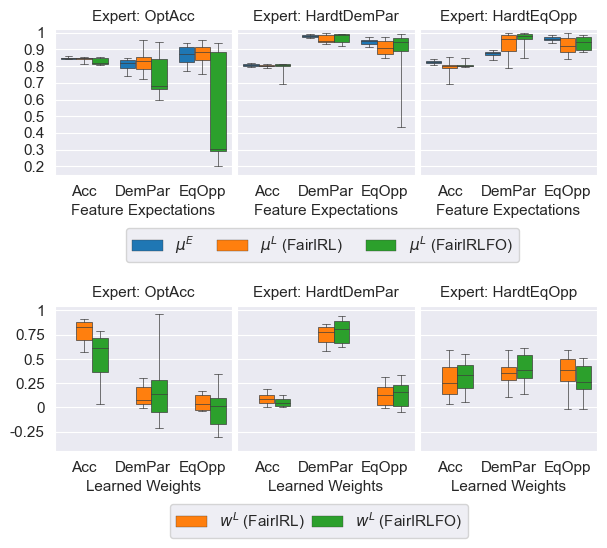

In [609]:
plt.rc('axes', titlesize=11)     # fontsize of the axes title
plt.rc('axes', labelsize=11)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=11)    # fontsize of the tick labels
plt.rc('ytick', labelsize=11)    # fontsize of the tick labels
plt.rc('ytick', labelsize=11)    # fontsize of the tick labels
plt.rc('legend', fontsize=11)    # legend fontsize
plt.rc('figure', titlesize=11)  # fontsize of the figure title

fig, axes, mu_dfs, w_dfs = plot_results_source_domain_only(
    objective_set_names=['Acc', 'DemPar', 'EqOpp'],
    expert_algos=[
        'OptAcc',
        'HardtDemPar',
        'HardtEqOpp',
    ],
    dataset=base_exp_info['DATASET'],
    mu_noise_factor=.01,
    w_noise_factor=.1,
    mu_hue_order=['muE', 'muL (FairIRL)', 'muL (FairIRLFO)'],
    w_hue_order=[None, 'wL (FairIRL)', 'wL (FairIRLFO)'],
    extra_skip_conditions=skip_by_name,
    min_exp_timestamp=min_exp_timestamp,
#     min_mu_value=.25,
#     max_mu_value=1,
#     min_w_value=-1,
    mu_yticks=[.1, .2, .3, .4, .5, .6, .7, .8, .9, 1],
    mu_ylim=(.15, 1.02),
    mu_whis=[5, 95],
    w_yticks = [-.25, 0, .25, .5, .75, 1],
    w_ylim=(-.45, 1.05),
    w_whis=[5, 95]
)

# Compare results with target domain

SOURCE DATASET: Boston
TARGET DATASET: COMPAS


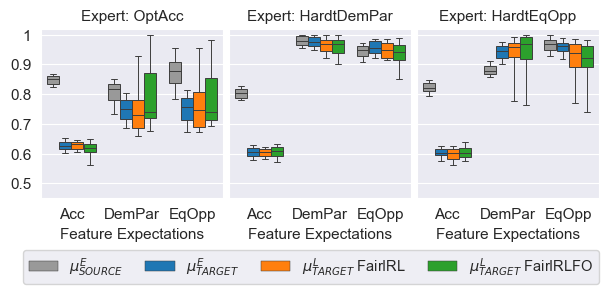

In [590]:
## plt.rc('axes', titlesize=11)     # fontsize of the axes title
plt.rc('axes', labelsize=11)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=11)    # fontsize of the tick labels
plt.rc('ytick', labelsize=11)    # fontsize of the tick labels
plt.rc('legend', fontsize=10.5)    # legend fontsize
plt.rc('figure', titlesize=11)  # fontsize of the figure title

mu_df, w_df = plot_results_target_domain(
    objective_set_names=['Acc', 'DemPar', 'EqOpp'],
    expert_algos=['OptAcc', 'HardtDemPar', 'HardtEqOpp'],
    source_dataset=base_exp_info['DATASET'],
    target_dataset=base_exp_info['TARGET_DATASET'],
    mu_noise_factor=.05,
    extra_skip_conditions=skip_by_name,
    min_exp_timestamp=min_exp_timestamp,
    min_mu_value=.5,
#     mu_yticks=[.6, .7, .8, .9, 1],
    mu_yticks=[.4, .5, .6, .7, .8, .9, 1],
    mu_ylim=(.45, 1.02),
    mu_whis=[5, 95],
)

# Scratch